## Predicting Apartment Prices in Mexico City 

Goal: A consolidation of the contents in 0-price-and size, 1-price-and-location, 2-price-and-neighborhood, and price-and-everything using the mexico dataset.

In [9]:
# Import libraries here
from glob import glob

import pandas as pd
import numpy as np

import seaborn as sns
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import matplotlib.pyplot as plt
import plotly.express as px

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

### Prepare Data

#### Import

In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Subset data: Apartments in "Distrito Federal", less than 100, 0000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    
    # subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # split lat and lon columns
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Create a feature "borough"
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop columns with more than 50% null values
    df.drop(columns =["surface_total_in_m2",
                      "price_usd_per_m2",
                      "rooms",
                      "floor",
                      "expenses"], inplace=True)
    # Drropp columns with low and high cardinality categiorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # drop leaky columns
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)
    
    # drop columns with multicollinearity
    None
    return df

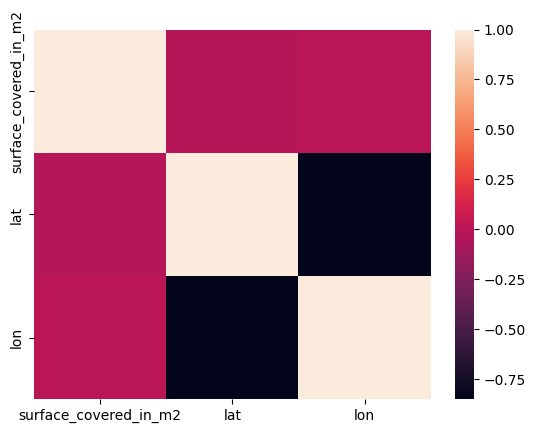

In [4]:
# Testing wrangle function and explore the data
files = glob("data/mexico-city-real-estate*.csv")
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
corr = round(df.select_dtypes("number").drop(columns="price_aprox_usd").corr(), 4)
sns.heatmap(corr);

Collect files using glob function

In [5]:
file = glob("data/mexico-city-real-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

Create a DataFrame

In [6]:
df = pd.concat([wrangle(file) for file in files])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


#### Explore

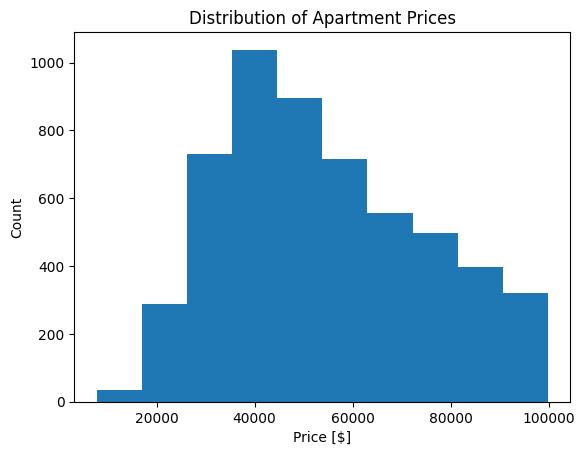

In [11]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices");
plt.savefig("images/2-5-4.png", dpi=150)
